In [3]:
interaction_matrix = sparse.load_npz('../data/interaction_matrix_ALL_species.npz')
targetNames = pd.read_csv('../data/all_targets', header=None).to_numpy().reshape(1,-1)[0]
targetIndex = (targetNames=='G-protein coupled receptor 55').nonzero()[0][0]

In [16]:
import pandas as pd
import numpy as np
from scipy import sparse
from tqdm import tqdm
from scipy.stats.mstats import rankdata

import sys
sys.path.append("..")
import utils

#Load up large interaction matrix (human, rat, mouse proteins with >150 interactions each)
interaction_matrix = sparse.load_npz('../data/interaction_matrix_ALL_species.npz')

#Get the index of the GPR55 column:
targetNames = pd.read_csv('../data/all_targets', header=None).to_numpy().reshape(1,-1)[0]
targetIndex = (targetNames=='G-protein coupled receptor 55').nonzero()[0][0]



##Fit top three algorithms on the interaction matrix:
#LightFM is slower than the other two.
filenames = ['label_correlation']

algorithms = [
                  utils.train_label_correlation]

preds_list = list()
ranks_list = list()
for name, algo in zip(filenames, algorithms):
        print(name)
        if name == 'label_correlation':
            preds = algo(interaction_matrix)
            preds_list.append( preds[:,targetIndex].toarray().flatten() )
        else:
            params = utils.read_params(name)
            preds = algo(params, interaction_matrix)
            for _ in tqdm(range(0)):
                preds += algo(params, interaction_matrix)
        preds_list.append(preds[:,targetIndex])

  0%|          | 187/200945 [00:00<01:47, 1866.44it/s]

label_correlation
y_in shape is: (630617, 852)


  2%|▏         | 3331/200945 [00:01<01:28, 2225.69it/s]


KeyboardInterrupt: 

In [15]:
preds[:,targetIndex].toarray().flatten()

array([0.        , 0.01254061, 0.00206612, ..., 0.        , 0.        ,
       0.00508623], dtype=float32)

In [5]:
##Next, for each set of predictions, get the ranking
##of only the unknown ligands (i.e. mask and remove the
##known true positives)

ranks_list = list()
#mask to remove the true positives:
true_pos = interaction_matrix[:,targetIndex].toarray().T[0]==1

for preds in tqdm(preds_list):
    ranks = rankdata(-preds[~true_pos])
    ranks_list.append(ranks)

##Finally, take the geometric average of the three sets of ranks:
##to get a consensus set of rank orders:
geo_ranks =np.power(ranks_list[0], 1)

#this now returns the indices that give you the top ranked ligands.
ranked_indices = geo_ranks.argsort()

100%|██████████| 1/1 [00:01<00:00,  1.15s/it]


In [6]:
##Save top results:
#load all chemical smiles:
allSmiles = pd.read_csv('../data/all_chemicals')
#get top 2000 predicted unknowns
predicted_smiles = allSmiles.iloc[~true_pos].iloc[ranked_indices[:2000]][['instance_id', 'canonical_smiles']]
#and keep the smiles for the true positives as well:
true_smiles = allSmiles.iloc[true_pos][['instance_id', 'canonical_smiles']]

In [7]:
predicted_smiles.to_csv('predicted_smiles.csv', header=0, index=False)
true_smiles.to_csv('true_smiles.csv', header=0, index=False)

In [4]:
#test = sparse.lil_matrix((interaction_matrix.shape[0],interaction_matrix.shape[1]))
#test[:,targetIndex]=1
#test = sparse.csr_matrix(test)

In [6]:
##This takes a while (basically lightfm is slower)

def calc_ranks_given_name(name, algo, train, test):
    if name == 'label_correlation':
        preds = algo(train)
    else:
        params = utils.read_params(name)
        preds = algo(params, train)
        for _ in range(7):
            preds += algo(params, train)
    ranks = utils.evaluate_predictions(preds, test, train)
    return ranks

filenames = ['label_correlation', 'hpo_implicit_bpr']#,
             #'hpo_lightfm_warp']

##Functions to train those algorithms:
algorithms = [utils.train_label_correlation,
                  utils.train_implicit_bpr,
                  utils.train_lightfm_warp]


preds_list = list()
ranks_list = list()
for name, algo in zip(filenames, algorithms):
        print(name)
        if name == 'label_correlation':
            preds = algo(interaction_matrix)
        else:
            params = utils.read_params(name)
            preds = algo(params, interaction_matrix)
            for _ in range(7):
                preds += algo(params, interaction_matrix)
        preds_list.append(preds[:,targetIndex])

  0%|          | 222/200945 [00:00<01:34, 2127.29it/s]

label_correlation
y_in shape is: (630617, 852)


100%|██████████| 630617/630617 [01:34<00:00, 6654.37it/s]


hpo_implicit_bpr


In [133]:
ranks_list

[array([418733.5,   8669. , 132434. , ..., 418733.5, 418733.5,  50092.5]),
 array([484585., 531363., 163640., ..., 583688., 259887., 368518.])]

In [58]:
m = (interaction_matrix[:,targetIndex].toarray()==1).flatten()

In [57]:
across_sum = np.array(interaction_matrix.sum(axis=1)).flatten()
across_sum



array([ 1., 47.,  1., ...,  2.,  1.,  4.])

In [116]:
import copy
name = 'hpo_implicit_bpr'
pos_indices = np.logical_and(across_sum>1, m).nonzero()[0]
record_ranks =list()
for p in np.random.choice(pos_indices, 10, replace=False):
    copy_matrix = copy.copy(interaction_matrix)
    copy_matrix[p,targetIndex]=0
    

    params = utils.read_params(name)
    print('training')
    preds = algo(params, interaction_matrix)
    #for _ in tqdm_notebook(range(3)):
    #    preds += algo(params, interaction_matrix)
    print('ranking:')
    ma_preds = np.ma.masked_array(-preds[:,targetIndex], mask=copy_matrix[:,targetIndex].toarray().flatten().astype(bool))
    
    ranks = rankdata(ma_preds)
    missing_rank = ranks[p]
    print(missing_rank)
    record_ranks.append(missing_rank)
    
    

training
ranking:
19.0
training
ranking:
100.0
training
ranking:
4.0
training
ranking:
14.0
training
ranking:
6.0
training
ranking:
24.0
training
ranking:
3.0
training
ranking:
15.0
training
ranking:
41.0
training
ranking:
4.0


In [117]:
name = 'hpo_implicit_bpr'
pos_indices = np.logical_and(across_sum>1, m).nonzero()[0]
record_ranks =list()
for p in np.random.choice(pos_indices, 100, replace=False):
    copy_matrix = copy.copy(interaction_matrix)
    copy_matrix[p,targetIndex]=0
    

    params = utils.read_params(name)
    print('training')
    preds = algo(params, interaction_matrix)
    #for _ in tqdm_notebook(range(3)):
    #    preds += algo(params, interaction_matrix)
    print('ranking:')
    ma_preds = np.ma.masked_array(-preds[:,targetIndex], mask=copy_matrix[:,targetIndex].toarray().flatten().astype(bool))
    
    ranks = rankdata(ma_preds)
    missing_rank = ranks[p]
    print(missing_rank)
    record_ranks.append(missing_rank)
    
    

training
ranking:
16.0
training
ranking:
1.0
training
ranking:
16.0
training
ranking:
58.0
training
ranking:
90.0
training
ranking:
5.0
training
ranking:
46.0
training
ranking:
14.0
training
ranking:
22.0
training
ranking:
5.0
training
ranking:
26.0
training
ranking:
69.0
training
ranking:
24.0
training
ranking:
47.0
training
ranking:
215.0
training
ranking:
358.0
training
ranking:
53.0
training
ranking:
54.0
training
ranking:
39.0
training
ranking:
446.0
training
ranking:
11.0
training
ranking:
24.0
training
ranking:
99.0
training
ranking:
68.0
training
ranking:
222.0
training
ranking:
22.0
training
ranking:
6.0
training
ranking:
78.0
training
ranking:
302.0
training
ranking:
25.0
training


KeyboardInterrupt: 

(0, 100)

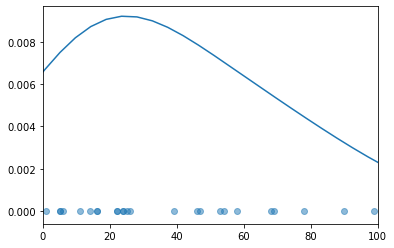

In [126]:
kdeplot(record_ranks)
plt.scatter(record_ranks, np.zeros(len(record_ranks)),alpha=0.5)
plt.xlim(0,100)

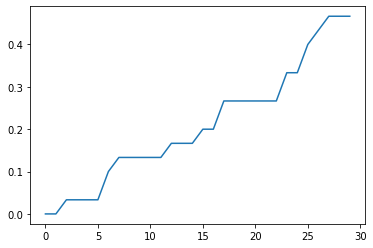

In [130]:
plt.plot([(np.array(record_ranks)<i).sum()/len(record_ranks) for i in range(30)])

In [134]:
#Trying with label corr:
preds = utils.train_label_correlation(interaction_matrix)


  0%|          | 154/200928 [00:00<02:10, 1534.48it/s]

y_in shape is: (630617, 852)



 37%|███▋      | 74283/200928 [00:29<00:52, 2433.36it/s]


 73%|███████▎  | 147346/200928 [01:05<00:16, 3199.44it/s]


  9%|▊         | 53979/630617 [00:09<01:45, 5442.67it/s]


 32%|███▏      | 204118/630617 [00:37<01:15, 5642.04it/s]


 60%|██████    | 378786/630617 [01:04<00:36, 6841.98it/s]


 88%|████████▊ | 553208/630617 [01:32<00:13, 5570.35it/s]


100%|██████████| 630617/630617 [01:46<00:00, 5945.16it/s]

In [163]:
pos_indices = np.logical_and(across_sum>1, m).nonzero()[0]
#pre = preds.toarray()
print('ranking:')
ranks = rankdata(-pre[:,targetIndex])
lc_ranks = list()


ranking:


In [150]:
name = 'hpo_implicit_bpr'
pos_indices = np.logical_and(across_sum>1, m).nonzero()[0]
#record_ranks =list()

params = utils.read_params(name)
print('training')
preds = algo(params, interaction_matrix)
print('ranking:')
ranks = rankdata(-preds[:,targetIndex])

training
ranking:


(0, 150)

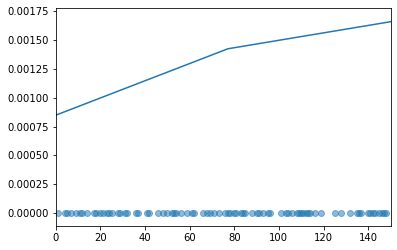

In [159]:
kdeplot(ranks[pos_indices])
plt.scatter(ranks[pos_indices], np.zeros(len(pos_indices)), alpha=0.5)
plt.xlim(0,150)

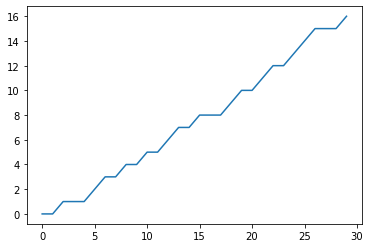

In [161]:
record_ranks = ranks[pos_indices]
plt.plot([(record_ranks<i).sum() for i in range(30)])

In [136]:
preds

<630617x852 sparse matrix of type '<class 'numpy.float32'>'
	with 142266238 stored elements in Compressed Sparse Row format>

In [111]:
~copy_matrix[:,targetIndex].toarray().flatten().astype(bool)

array([ True,  True,  True, ...,  True,  True,  True])

In [114]:
np.array([False,False,False,True,True,True])

array([False, False, False,  True,  True,  True])

In [115]:
test_arr = np.array([1,1,1,2,2,2])
test_ma = np.ma.masked_array(test_arr, mask=np.array([False,False,False,True,True,True]))
print(np.mean(test_ma))#

1.0


In [101]:
ma_preds = np.ma.masked_array(-preds[:,targetIndex], mask=~copy_matrix[:,targetIndex].toarray().flatten().astype(bool))

In [106]:
ma_preds.data[ma_preds.mask].shape

(630106,)

In [73]:
across_sum>1

array([False,  True, False, ...,  True, False,  True])

In [7]:
preds_list[0] = preds_list[0].toarray().T[0]

In [8]:
ranks_list = list()
#mask to remove the true positives:
true_pos = interaction_matrix[:,targetIndex].toarray().T[0]==1

for preds in tqdm_notebook(preds_list):
    ranks = rankdata(-preds[~true_pos])
    ranks_list.append(ranks)

In [175]:
allSmiles.iloc[~true_pos].iloc[ranked_indices[:1000]][['instance_id', 'canonical_smiles']]

,instance_id,canonical_smiles
180318,CHEMBL1713756,COc1ccc(cc1)n2cc3c(nnc(C)c3n2)c4ccc(cc4)c5ccccc5
140034,CHEMBL1542604,COc1ccc(c(O)c1)c2[nH]nc(C)c2c3ccc(Cl)cc3
57527,CHEMBL1354658,FC(F)(F)CCCS(=O)(=O)Oc1cccc(Oc2cccc(c2C#N)C(F)...
194687,CHEMBL181633,COc1ccc(cc1)C(=O)c2c(C)n(CCN3CCOCC3)c4cc(I)ccc24
217136,CHEMBL1981103,CC(C)CC1NC(=O)C23C(C=C(C)C(C)C12)\C=C(/C)\CCC(...
491384,CHEMBL393018,COc1ccc(cc1S(=O)(=O)N2CCOCC2)C(=O)Oc3cccc4cccnc34
525638,CHEMBL39878,CCCCC\C=C/C\C=C/C\C=C/C\C=C/CCCC(=O)Nc1ccc(O)cc1
201883,CHEMBL188,Cc1c(C(=O)c2cccc3ccccc23)c4cccc5OC[C@@H](CN6CC...
178890,CHEMBL16901,Oc1ccc(cc1CC=C)c2cc(CC=C)ccc2O
571058,CHEMBL466853,[I-].CCN1\C(=C\C(=C\c2sc3ccccc3[n+]2CC)\C)\Sc4...


In [173]:
predicted_smiles.to_csv('test.csv', header=0, index=False)

In [12]:
geo_ranks =np.power(ranks_list[0] * ranks_list[1], 1/2)
ranked_indices = geo_ranks.argsort()

In [127]:
allSmiles =pd.read_csv('../data/all_chemicals')

predicted_smiles = allSmiles.iloc[~true_pos].iloc[ranked_indices[:1000]]['canonical_smiles']
true_smiles = allSmiles.iloc[true_pos]['canonical_smiles']


In [133]:
predicted_mols = [Chem.MolFromSmiles(i) for i in list(predicted_smiles)]
true_mols = [Chem.MolFromSmiles(i) for i in list(true_smiles)]

In [134]:
gen_mo = rdFingerprintGenerator.GetMorganGenerator(fpSize=1024, radius=2)
predicted_fp = [gen_mo.GetFingerprint(mol) for mol in predicted_mols]
true_fp = [gen_mo.GetFingerprint(mol) for mol in true_mols]

In [164]:
similarities = list()
for m in predicted_fp:
    similarities.append(max([DataStructs.TanimotoSimilarity(m, i) for i in true_fp]))

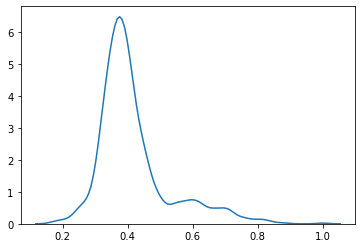

In [32]:
kdeplot(similarities)

/Users/lmar3213/miniconda3/envs/lew_conda/lib/python3.7/site-packages/rdkit/Chem/Draw/IPythonConsole.py:183: UserWarning: Truncating the list of molecules to be displayed to 100. Change the maxMols value to display more.
  % (maxMols))


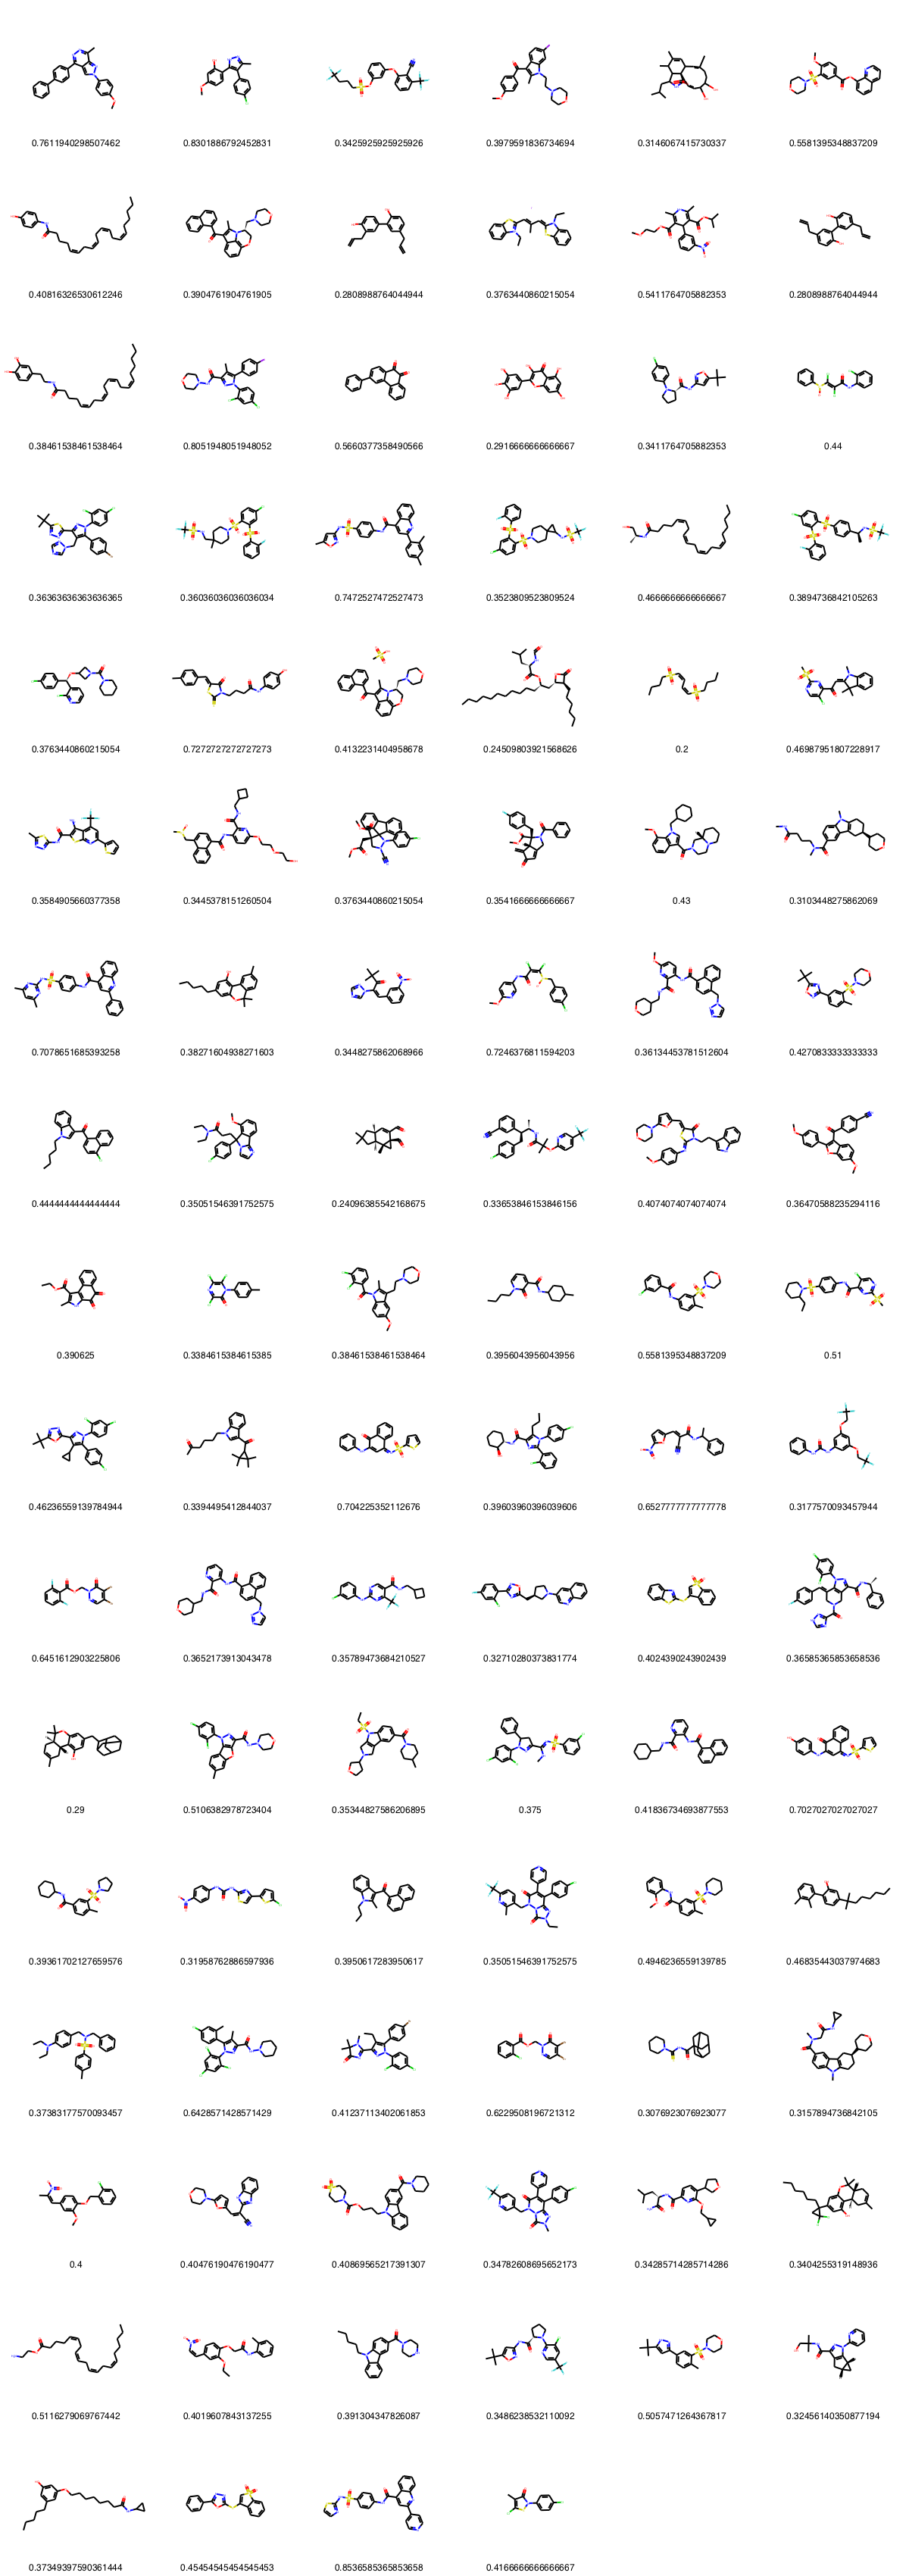

In [31]:
Draw.MolsToGridImage(predicted_mols, molsPerRow=6, legends=[str(i) for i in similarities[:100]], maxMols=100)

In [1]:
indices = np.random.choice(len(true_mols), 50)
Draw.MolsToGridImage(np.array(true_mols)[indices], 
                     molsPerRow=6, 
                     legends=list(np.array([str(i) for i in similarities])[indices]), 
                     maxMols=100)

NameError: name 'np' is not defined

In [27]:
allSmiles =pd.read_csv('../data/all_chemicals')

predicted_smiles = allSmiles.iloc[~true_pos].iloc[ranked_indices[:1000]]['canonical_smiles']
true_smiles = allSmiles.iloc[true_pos]['canonical_smiles']

In [28]:
predicted_mols = [Chem.MolFromSmiles(i) for i in list(predicted_smiles)]
true_mols = [Chem.MolFromSmiles(i) for i in list(true_smiles)]



In [35]:
indo = Chem.MolFromSmiles('CC1=C(C2=C(N1C(=O)C3=CC=C(C=C3)Cl)C=CC(=C2)OC)CC(=O)O')
indo_fp = gen_mo.GetFingerprint(indo)
indo_similarity = [DataStructs.TanimotoSimilarity(fp, indo_fp) for fp in predicted_fp]


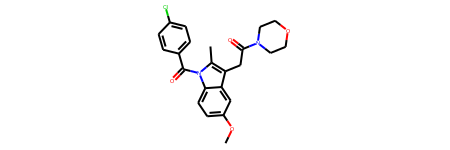

In [43]:
predicted_mols[np.argmax(indo_similarity)]

In [29]:
gen_mo = rdFingerprintGenerator.GetMorganGenerator(fpSize=1024, radius=2)
predicted_fp = list()
for mol in predicted_mols:
    try:
        predicted_fp.append(gen_mo.GetFingerprint(mol)) 
    except:
        pass
    
true_fp= [gen_mo.GetFingerprint(mol) for mol in true_mols]

In [30]:
similarities = list()
for m in tqdm_notebook(predicted_fp):
    similarities.append(max([DataStructs.TanimotoSimilarity(m, i) for i in true_fp]))